In [6]:
import pandas as pd
import numpy as np
import time
import seaborn as sns
from itertools import combinations
from sklearn import model_selection, linear_model, metrics
sns.set(rc={'figure.figsize':(10,10)})

### Naive Algorithm

In [9]:
def n_choose_k(n, k):
    return int(np.math.factorial(n) / (np.math.factorial(n - k) * np.math.factorial(k)))

def n_choose_upto_k_sum(n, up_to_k):
    return np.array([n_choose_k(n, k) for k in range(1, up_to_k + 1)]).sum()
    
def best_subset(n_predictors, target_column, data):
    i = 1
    predictors = data.drop(target_column, axis=1).columns
    search_size = n_choose_upto_k_sum(len(predictors), n_predictors)
    single_fit_time = 0.0012
    print('searching over {} models'.format(search_size))
    print('estimated time: {} seconds'.format(single_fit_time * search_size))
    top_models = []
    top_combs = []
    loop_tick = time.time() 
    while i <= n_predictors:
        print('-----------')
        print('{} choose: {}'.format(n_predictors, i))
        cmbs = list(combinations(predictors, i))
        print('{} combinations'.format(len(cmbs)))
        tick = time.time()
        top_model = None
        top_score = None
        top_comb = None
        for s in cmbs:
            x = data[list(s)]
            model = linear_model.LinearRegression().fit(x, data[target_column])
            # `score` calculates R^2
            score = model.score(x, data[target_column])
            if top_score == None or score > top_score:
                top_model = model
                top_score = score
                top_comb = s
        tock = time.time()
        print('done: {} seconds ({} secs/model)'.format(tock - tick, (tock - tick) / len(cmbs)))
        top_models.append(top_model)
        top_combs.append(top_comb)
        tock = time.time()
        i += 1
    
    print('--- FINISHED ---')
    loop_tock = time.time()
    print('total time: {} seconds'.format((loop_tock-loop_tick)))
    print('secs/model: {}'.format((loop_tock-loop_tick)/ search_size))
    return pd.DataFrame({'model' : top_models, 'n_predictors' : range(1, n_predictors + 1)}), top_combs

### Generate some data

In [10]:
def generate_example_data(n, p, beta, epsilon):
    x = np.random.normal(0, 1, (n, p))
    eps = np.random.normal(0, epsilon, n)
    y = (x @ beta.reshape(-1, 1)) + eps.reshape(-1, 1)
    data = pd.DataFrame(x, columns= ['x' + str(i) for i in range(0, x.shape[1])])
    data['y'] = y
    return model_selection.train_test_split(data, test_size=0.9)

def compute_rmses(combs, df, test):
    rmses = []
    for idx, m in enumerate(df['model']):
        comb = combs[idx]
        x = test[list(comb)]
        preds = m.predict(x)
        rmses.append(np.sqrt(metrics.mean_squared_error(test['y'], preds)))
    return rmses

Example 1: All the predictors are equally associated with the respone

searching over 1023 models
estimated time: 1.2275999999999998 seconds
-----------
10 choose: 1
10 combinations
done: 0.019714832305908203 seconds (0.0019714832305908203 secs/model)
-----------
10 choose: 2
45 combinations
done: 0.04935574531555176 seconds (0.0010967943403455947 secs/model)
-----------
10 choose: 3
120 combinations
done: 0.14224720001220703 seconds (0.0011853933334350585 secs/model)
-----------
10 choose: 4
210 combinations
done: 0.253493070602417 seconds (0.0012071098600115095 secs/model)
-----------
10 choose: 5
252 combinations
done: 0.31765222549438477 seconds (0.0012605247043427966 secs/model)
-----------
10 choose: 6
210 combinations
done: 0.2761421203613281 seconds (0.0013149624779110864 secs/model)
-----------
10 choose: 7
120 combinations
done: 0.1645829677581787 seconds (0.0013715247313181558 secs/model)
-----------
10 choose: 8
45 combinations
done: 0.06039309501647949 seconds (0.0013420687781439888 secs/model)
-----------
10 choose: 9
10 combinations
done: 0

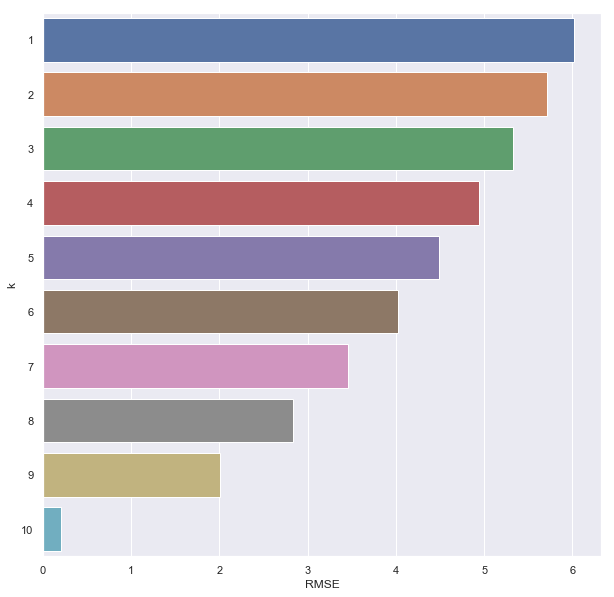

In [11]:
# generate data
n = 10000
p = 10
beta = np.repeat(2, p)
train, test = generate_example_data(n, p, beta, 0.2)
# search for best subset
df, combs = best_subset(10, 'y', train)

# evalutate test error for best model for each k
rmses = compute_rmses(combs, df, test)
    
# plot error vs k
bar_df = pd.DataFrame({'RMSE' : rmses,'k' : np.arange(1, len(rmses) + 1)})
sns.barplot(y='k', x='RMSE', data=bar_df, orient='h')

Example 2: Half of the predictors are equally associated with the respone, the rest are not associated with the response

searching over 1023 models
estimated time: 1.2275999999999998 seconds
-----------
10 choose: 1
10 combinations
done: 0.013470172882080078 seconds (0.0013470172882080079 secs/model)
-----------
10 choose: 2
45 combinations
done: 0.05158400535583496 seconds (0.0011463112301296659 secs/model)
-----------
10 choose: 3
120 combinations
done: 0.13752007484436035 seconds (0.001146000623703003 secs/model)
-----------
10 choose: 4
210 combinations
done: 0.25676608085632324 seconds (0.0012226956231253488 secs/model)
-----------
10 choose: 5
252 combinations
done: 0.3118247985839844 seconds (0.0012373999943808905 secs/model)
-----------
10 choose: 6
210 combinations
done: 0.2667369842529297 seconds (0.0012701761154901414 secs/model)
-----------
10 choose: 7
120 combinations
done: 0.1490161418914795 seconds (0.0012418011824289958 secs/model)
-----------
10 choose: 8
45 combinations
done: 0.056954145431518555 seconds (0.0012656476762559678 secs/model)
-----------
10 choose: 9
10 combinations
done: 

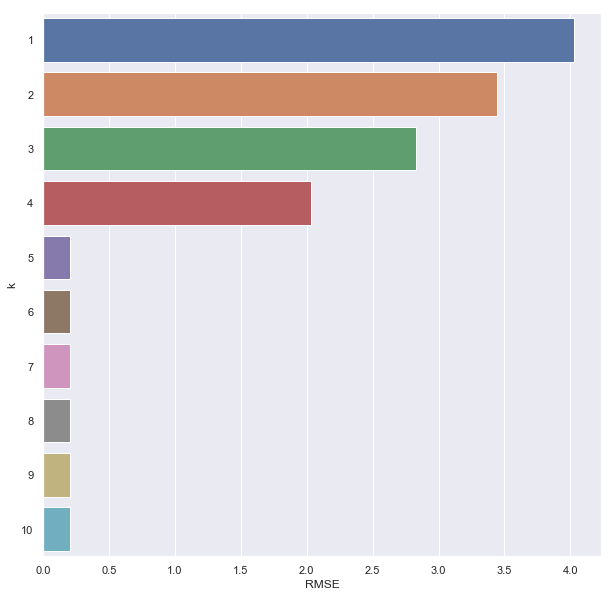

In [12]:
# generate data
n = 10000
p = 10
beta = np.append(np.repeat(0, 5), np.repeat(2, 5))
train, test = generate_example_data(n, p, beta, 0.2)
# search for best subset
df, combs = best_subset(10, 'y', train)

# evalutate test error for best model for each k
rmses = compute_rmses(combs, df, test)
    
# plot error vs k
bar_df = pd.DataFrame({'RMSE' : rmses,'k' : np.arange(1, len(rmses) + 1)})
sns.barplot(y='k', x='RMSE', data=bar_df, orient='h')

### Leaps and Bounds Algorithm

The algorithm described by Furnival, G. M. and Wilson, R. W., Jr. in their paper: *Regressions by leaps and bounds* can efficiently compute best subsets for `p` up to 30 or 40. [This](https://www.stat.umn.edu/geyer/8054/slide/leaps.pdf) deck describes the original paper as *"almost maximally unreadable"* but recommends Hand (1981) as a better penned alternative.